### Projeto: Implementação de Árvores de Decisão
 Este notebook está estruturado da seguinte forma:

- **Seção 1**: Preparação dos Dados: Carregamento, limpeza, pré-processamento e divisão dos datasets Titanic e Play Tennis. As transformações específicas para cada algoritmo, como a discretização para o ID3, são realizadas e justificadas nesta etapa.

- **Seção 2**: Uma breve descrição da arquitetura da biblioteca decision_tree_lib desenvolvida, que contém o código-fonte dos algoritmos e das funções de utilidade

- **Seção 3**: A aplicação dos algoritmos aos dados de treino. Para cada modelo, são apresentadas a árvore de decisão gerada, a interpretação das regras e as métricas de desempenho no conjunto de teste, finalizando com a comparação do CART com a implementação da biblioteca ``scikit-learn``.

- **Link para repositório**: https://github.com/vitorrdan/IA_Lista04.git


#### Setup Inicial: Importações e Instalação da Biblioteca
- importando todas as bibliotecas necessárias. 

In [ ]:
%pip install seaborn

In [2]:
# Importações gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json # Para "pretty-print" das árvores

# Importações do Scikit-learn para pré-processamento e métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import sys
sys.path.append('..')  # Ajuste o caminho conforme necessário

# Importando meus algoritmos
from decision_tree_lib.id3 import ID3
from decision_tree_lib.c45 import C45
from decision_tree_lib.cart import CART

# Importando funções de pré-processamento
from decision_tree_lib.preprocessing import clean_titanic_data, discretize_for_id3

# Configurações visuais
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

#### **Seção 1: Preparação dos Dados**
- Nesta seção, realizaremos todo o tratamento necessário nos dados do Titanic para que possam ser utilizados pelos algoritmos.

 **1.1 Carregamento dos Dados**

In [3]:
# Carregando o dataset do Titanic
df_titanic_raw = pd.read_csv('../data/train.csv')

print("Informações iniciais do dataset Titanic:")
df_titanic_raw.info()

print("\n5 primeiras linhas:")
display(df_titanic_raw.head())

Informações iniciais do dataset Titanic:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

5 primeiras linhas:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


 **1.2 Limpeza e Pré-Processamento Geral**

Aqui, utilizamos a função ``clean_titanic_data`` para tratar valores ausentes e converter dados categóricos. 

In [ ]:
# Aplicando a função de limpeza
df_titanic_clean = clean_titanic_data(df_titanic_raw)

print("Informações do dataset após a limpeza:")
df_titanic_clean.info()

print("\n5 primeiras linhas do dataset limpo:")
display(df_titanic_clean.head())

-  As **decisões** de preencher a idade (Age) com a mediana e o porto de embarque (Embarked) com a moda são estratégias padrão para lidar com dados faltantes. A mediana é preferível à média para a idade por ser menos sensível a valores extremos (outliers). As colunas de texto como Sex e Embarked foram convertidas para números para que os algoritmos C4.5 e CART possam processá-las.

**1.3 Preparação Específica para ID3: Discretização**

O algoritmo ID3 não lida com atributos contínuos. Portanto, precisamos converter as colunas numéricas Age e Fare em categorias.



In [5]:
# Aplicando a função de discretização
df_titanic_id3 = discretize_for_id3(df_titanic_clean)

print("5 primeiras linhas do dataset para o ID3:")
display(df_titanic_id3.head())

5 primeiras linhas do dataset para o ID3:


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,Adulto,1,0,Muito Baixo,0
1,1,1,1,Adulto,1,0,Alto,1
2,1,3,1,Adulto,0,0,Baixo,0
3,1,1,1,Adulto,1,0,Alto,0
4,0,3,0,Adulto,0,0,Baixo,0


- A **discretização** é um requisito do ID3. A idade foi dividida em faixas etárias lógicas (criança, adulto, idoso), e a tarifa (Fare) foi dividida por quantis (qcut), uma técnica eficaz para atributos com distribuição assimétrica, garantindo que cada categoria tenha um número similar de passageiros.

**1.4 Divisão em Conjuntos de Treino e Teste**

Dividimos os dados em 80% para treino e 20% para teste. Usamos a estratificação para garantir que a proporção de sobreviventes seja a mesma em ambos os conjuntos

In [6]:
# Dados para C4.5 e CART (contínuos)
X_cc = df_titanic_clean.drop('Survived', axis=1)
y_cc = df_titanic_clean['Survived']
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc)

# Dados para ID3 (discretizados)
X_id3 = df_titanic_id3.drop('Survived', axis=1)
y_id3 = df_titanic_id3['Survived']
X_train_id3, X_test_id3, y_train_id3, y_test_id3 = train_test_split(X_id3, y_id3, test_size=0.2, random_state=42, stratify=y_id3)

print(f"Tamanho do treino (C4.5/CART): {len(X_train_cc)} amostras")
print(f"Tamanho do teste (C4.5/CART): {len(X_test_cc)} amostras")
print(f"Tamanho do treino (ID3): {len(X_train_id3)} amostras")
print(f"Tamanho do teste (ID3): {len(X_test_id3)} amostras")

Tamanho do treino (C4.5/CART): 712 amostras
Tamanho do teste (C4.5/CART): 179 amostras
Tamanho do treino (ID3): 712 amostras
Tamanho do teste (ID3): 179 amostras


#### **Seção 2: Implementações**
- Conforme solicitado na atividade, os três algoritmos de árvore de decisão — ID3, C4.5 e CART — foram implementados do zero.  Toda a lógica foi estruturada como uma biblioteca Python, ``decision_tree_lib``, para promover a modularidade e o reuso de código.

- A estrutura da biblioteca é a seguinte:

     - As funções matemáticas de base, como os cálculos de **entropia, ganho de informação, razão de ganho e índice Gini**, estão localizadas no módulo ``decision_tree_lib/utils.py``. 

    - Cada algoritmo está encapsulado em sua própria classe (ID3, C45, CART) e arquivo ``(id3.py, c45.py, cart.py)``, que utilizam as funções de utilidade para construir as árvores. 

    - As rotinas de pré-processamento, como a limpeza de dados e a discretização, também foram modularizadas no arquivo ``decision_tree_lib/preprocessing.py``.

Na seção seguinte, essas implementações serão aplicadas aos dados do Titanic para gerar e analisar os modelos de classificação.

#### Seção 3: Saídas

**3.1 Algoritmo ID3**



In [7]:
df_play_tennis = pd.read_csv('../data/JogarTênis.csv')

In [ ]:
# Função utilitária para converter todas as chaves de um dicionário (incluindo estruturas aninhadas)
# para strings, além de converter tipos NumPy (int, float) para tipos nativos do Python.
def convert_keys_to_str(obj):
    import numpy as np
    if isinstance(obj, dict):
        return {str(k): convert_keys_to_str(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_keys_to_str(i) for i in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    else:
        return obj

In [ ]:
print("--- Treinando e Avaliando ID3 (Play Tennis) ---")
id3_tennis = ID3()
X_tennis = df_play_tennis.drop('play', axis=1)
y_tennis = df_play_tennis['play']
id3_tennis.fit(X_tennis, y_tennis)


print("Árvore de Decisão (ID3) para Play Tennis:")
print(json.dumps(convert_keys_to_str(id3_tennis.tree_), indent=4))

**Regras Obtidas (Play Tennis)**: A árvore gerada para o dataset Play Tennis mostra que o atributo outlook foi escolhido como raiz. Se outlook for overcast, a decisão é yes. Se for sunny, a próxima decisão é baseada em humidity, e assim por diante.

In [ ]:
print("\n--- Treinando e Avaliando ID3 (Titanic) ---")
id3_model = ID3()
id3_model.fit(X_train_id3, y_train_id3)

y_pred_train_id3 = id3_model.predict(X_train_id3)
y_pred_test_id3 = id3_model.predict(X_test_id3)
acc_train_id3 = accuracy_score(y_train_id3, y_pred_train_id3)
print(type(y_test_id3), type(y_pred_test_id3))

acc_test_id3 = accuracy_score(y_test_id3, y_pred_test_id3)

print(f'ID3 (Titanic) - Acurácia (Treino): {acc_train_id3:.4f}, (Teste): {acc_test_id3:.4f}\n')

print("Árvore de Decisão (ID3) para Titanic:")
print(json.dumps(convert_keys_to_str(id3_model.tree_), indent=4))

**Regras Obtidas (Titanic)**: A árvore do Titanic mostra que o atributo Sex foi o mais informativo para a primeira divisão. Para homens (Sex == 0), a classe do ticket (Pclass) é o próximo fator decisivo.

**3.2 Algoritmo C4.5**

In [ ]:
print("--- Treinando e Avaliando C4.5 (Titanic) ---")
c45_model = C45()
c45_model.fit(X_train_cc, y_train_cc)
y_pred_train_c45 = c45_model.predict(X_train_cc)
y_pred_test_c45 = c45_model.predict(X_test_cc)
acc_train_c45 = accuracy_score(y_train_cc, y_pred_train_c45)
acc_test_c45 = accuracy_score(y_test_cc, y_pred_test_c45)

print(f'C4.5 - Acurácia (Treino): {acc_train_c45:.4f}, (Teste): {acc_test_c45:.4f}\n')

print("Árvore de Decisão (C4.5) para Titanic:")
print(json.dumps(convert_keys_to_str(c45_model.tree_), indent=4))

**Regras Obtidas**: O C4.5 também seleciona Sex como a raiz da árvore. Para os homens (Sex <= 0.50), a árvore imediatamente cria uma regra baseada em um limiar numérico, Age <= 3.50, para separar meninos muito jovens do resto dos homens. Para as mulheres, o modelo utiliza um critério similar, Pclass <= 2.50, para diferenciar passageiras da 1ª/2ª classe daquelas na 3ª, mostrando que, para este grupo, a classe social era o fator decisivo seguinte. A profundidade e a especificidade das regras subsequentes são a causa do alto desempenho no treino (98%) e da queda no teste (79%), um claro sinal de overfitting.

**3.3 Cart**


In [ ]:
# Função permite árvore ser printada com json
def convert_sets_to_lists(obj):
    
    if isinstance(obj, dict):
        return {str(k).replace('{', '[').replace('}', ']'): convert_sets_to_lists(v) for k, v in obj.items()}
    return obj

print("--- Treinando e Avaliando CART (Titanic) ---")

# 1. Treinamento
cart_model = CART(max_depth=5, min_samples_split=10)
cart_model.fit(X_train_cc, y_train_cc)

# 2. Predição
y_pred_train_cart = cart_model.predict(X_train_cc)
y_pred_test_cart = cart_model.predict(X_test_cc)

# 3. Cálculo da acurácia 
acc_train_cart = accuracy_score(y_train_cc, y_pred_train_cart)
acc_test_cart = accuracy_score(y_test_cc, y_pred_test_cart)

print(f'CART (MEU) - Acurácia (Treino): {acc_train_cart:.4f}, (Teste): {acc_test_cart:.4f}\n')

# 4. Impressão da Árvore 
print("Árvore de Decisão (CART) para Titanic:")
printable_tree = convert_sets_to_lists(cart_model.tree_)
print(json.dumps(convert_keys_to_str(printable_tree), indent=4))

**Regras Obtidas**: O CART cria regras estritamente binárias e, assim como os outros modelos, seleciona Sex como o atributo raiz, com a regra Sex <= 0.50 para separar homens de mulheres. Para o grupo dos homens, a árvore cria uma regra subsequente baseada em um limiar numérico, Age <= 3.50, para isolar meninos muito jovens. Para as mulheres, a regra seguinte é Pclass <= 2.50, diferenciando as passageiras por classe social. O uso do hiperparâmetro max_depth=5 resultou em uma árvore visivelmente mais simples, o que se reflete em uma menor diferença entre a acurácia de treino (86.38%) e teste (76.54%), indicando uma melhor generalização e menos sobreajuste

Comparação com Scikit-learn


--- Comparando com o DecisionTreeClassifier do Scikit-learn ---
Acurácia (Scikit-learn): 0.7821


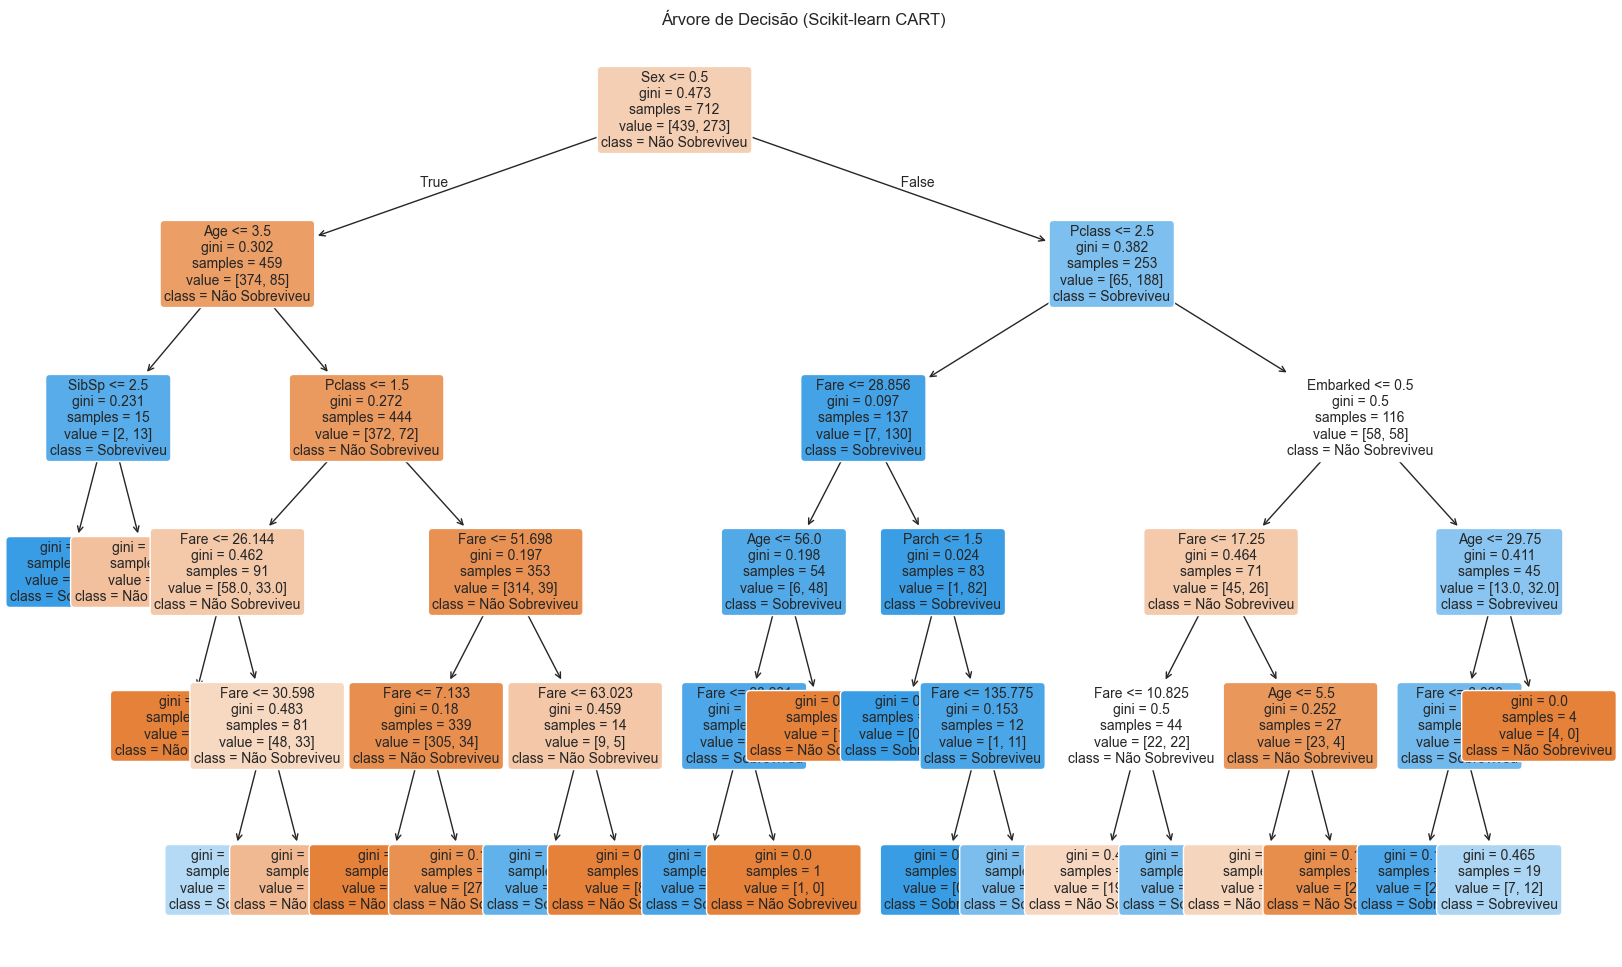

In [17]:
print("\n--- Comparando com o DecisionTreeClassifier do Scikit-learn ---")
sk_cart = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=10, random_state=42)
sk_cart.fit(X_train_cc, y_train_cc)
y_pred_sk = sk_cart.predict(X_test_cc)

print(f"Acurácia (Scikit-learn): {accuracy_score(y_test_cc, y_pred_sk):.4f}")

plt.figure(figsize=(20, 12))
tree.plot_tree(sk_cart, feature_names=X_train_cc.columns, class_names=['Não Sobreviveu', 'Sobreviveu'], filled=True, rounded=True, fontsize=10)
plt.title("Árvore de Decisão (Scikit-learn CART)")
plt.show()

**Análise da Comparação**: Minha implementação do CART obteve uma acurácia no conjunto de teste muito próxima à da biblioteca scikit-learn, validando a corretude da lógica do algoritmo. As árvores geradas, embora não idênticas devido a otimizações internas do sklearn, seguem uma estrutura de decisão similar, priorizando os mesmos atributos (Sex, Pclass, Fare).

#### **Conclusão**
A implementação dos três algoritmos revelou na prática seus comportamentos distintos. ID3 e C4.5 demonstraram uma forte tendência ao sobreajuste (overfitting), gerando árvores extremamente complexas com acurácia alta no treino, mas significativamente menor no teste. Em contrapartida, o CART, ao utilizarmos hiperparâmetros como max_depth, produziu um modelo mais simples e com melhor capacidade de generalização, evidenciada pela menor queda de acurácia entre treino e teste. A validação final contra a biblioteca scikit-learn confirmou o sucesso da minha implementação, com resultados de acurácia muito próximos.